<a href="https://colab.research.google.com/github/yair040/AI_Course_Ramat_Gan-/blob/main/Lesson39_CNN_Classification_PyTorch/cats_dogs_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐱 vs 🐶 Cat / Dog Image Classifier
## CNN Binary Classification with PyTorch
**Author:** Yair Levi  
**Platform:** Google Colab + PyTorch  

---
### 📋 Setup Instructions
1. Enable GPU: **Runtime → Change runtime type → T4 GPU**
2. Mount Google Drive (see cell below) and place your images at:
   - `MyDrive/cats_dogs/cats/` — 1,500 cat images
   - `MyDrive/cats_dogs/dogs/` — 1,500 dog images
3. Run all cells top-to-bottom (**Runtime → Run all**)

---
### 📚 What This Notebook Covers
| Step | Description |
|------|-------------|
| 1 | Mount drive & load images |
| 2 | Visualize sample images |
| 3 | Preprocessing (resize, normalize, labels) |
| 4 | CNN architecture |
| 5 | Train/Test split |
| 6 | Training with Adam + loss/accuracy curves |
| 7 | Evaluation + confusion matrix + error analysis |
| 8 | Improvement experiments |


## ⚙️ Step 0 — Install Dependencies & Mount Google Drive

We start by installing any extra packages not built into Colab and mounting Google Drive so we can access the image folders.

- **torchsummary** gives us a Keras-style `model.summary()` printout.
- **seaborn** is used for the confusion matrix heatmap.
- `drive.mount()` links `/content/drive` to your Google Drive root.

In [1]:
# Install extra packages
!pip install torchsummary seaborn -q

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print('Drive mounted. GPU available:', __import__('torch').cuda.is_available())

Mounted at /content/drive
Drive mounted. GPU available: True


## 📦 Step 0b — Import Libraries

We import all the Python libraries used throughout the notebook:

- **torch / torchvision**: PyTorch deep learning framework and computer vision utilities.
- **matplotlib / seaborn**: Plotting and visualization.
- **sklearn.metrics**: Confusion matrix and classification report.
- **numpy**: Numerical operations.
- **os / random**: File system traversal and random sampling.

In [2]:
import os, random, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


## 🗂️ Step 1 — Load Images from Google Drive

We point PyTorch's `ImageFolder` loader at the parent directory that contains both `cats/` and `dogs/` sub-folders.  
`ImageFolder` automatically:
- Discovers sub-folder names as class labels.
- Assigns integer indices: `cats → 0`, `dogs → 1`.
- Loads each image on demand using PIL.

At this stage we apply **only** the resize transform (no normalization yet) so that the images we display in the next cell look natural.

In [3]:
# ── Path to your dataset on Google Drive ─────────────────────────────────────
# Adjust this path if your folder structure is different.
DATA_DIR = '/content/drive/MyDrive/cats_dogs'
# If running locally, uncomment the line below instead:
# DATA_DIR = '.'   # expects ./cats/ and ./dogs/ in the current directory

# ── Minimal transform for visualization (resize only) ────────────────────────
viz_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=viz_transform)

print(f'Total images loaded : {len(full_dataset)}')
print(f'Class mapping       : {full_dataset.class_to_idx}')

Total images loaded : 3000
Class mapping       : {'cats': 0, 'dogs': 1}


## 🖼️ Step 1b — Visualize Sample Images

Before building any model we always look at the raw data. This helps us:
1. Confirm the images loaded correctly.
2. Get a sense of the variety in lighting, pose, and background across both classes.
3. Spot obvious data-quality issues (corrupt files, wrong labels, etc.).

We randomly pick 5 cats and 5 dogs from the full dataset and display them in a 2-row grid.

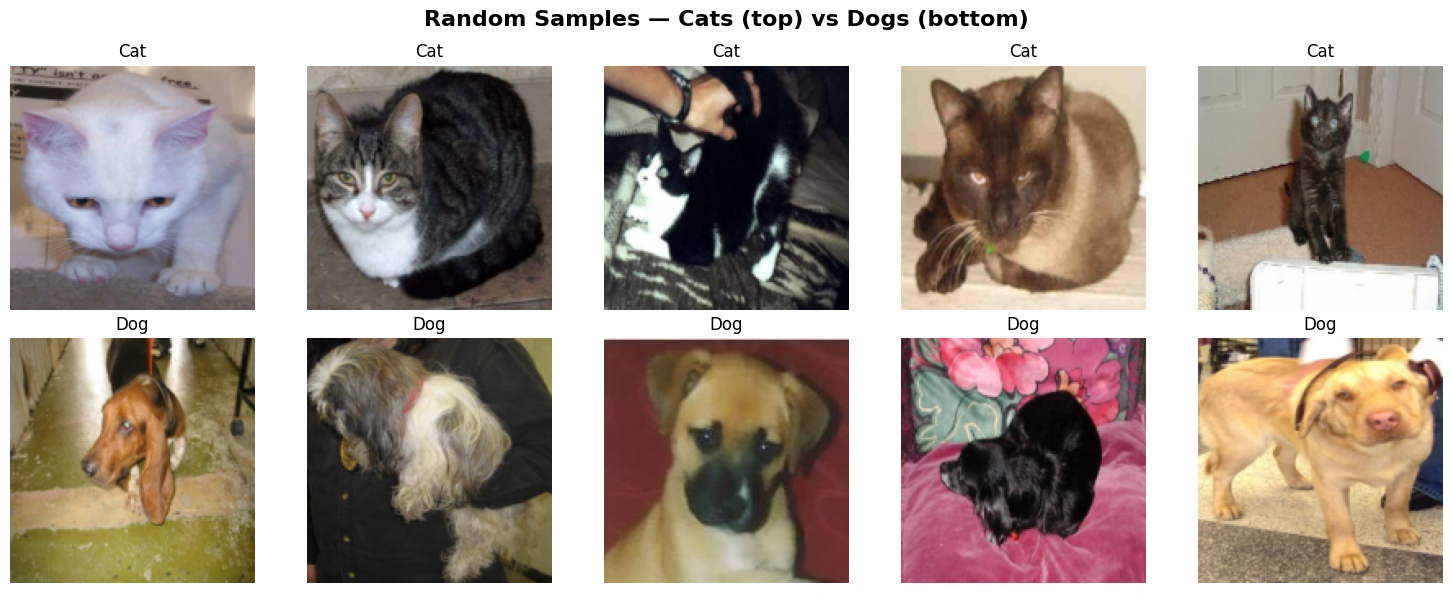

In [4]:
CLASS_NAMES = ['Cat', 'Dog']

def show_samples(dataset, n_per_class=5, title='Sample Images'):
    """Display n_per_class images for each class in a grid."""
    cat_indices = [i for i, (_, lbl) in enumerate(dataset.samples) if lbl == 0]
    dog_indices = [i for i, (_, lbl) in enumerate(dataset.samples) if lbl == 1]

    chosen = random.sample(cat_indices, n_per_class) + random.sample(dog_indices, n_per_class)
    fig, axes = plt.subplots(2, n_per_class, figsize=(3 * n_per_class, 6))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for col, idx in enumerate(chosen):
        img_tensor, label = dataset[idx]
        img = img_tensor.permute(1, 2, 0).numpy()   # C,H,W → H,W,C for matplotlib
        row = 0 if col < n_per_class else 1
        c   = col if col < n_per_class else col - n_per_class
        axes[row, c].imshow(img)
        axes[row, c].set_title(CLASS_NAMES[label], fontsize=12)
        axes[row, c].axis('off')

    plt.tight_layout()
    plt.show()

show_samples(full_dataset, n_per_class=5, title='Random Samples — Cats (top) vs Dogs (bottom)')

## ✂️ Step 2 — Train / Test Split

We need exactly **1,000 training images and 500 test images per class**.

**Strategy:**
1. Separate the indices for each class.
2. Randomly shuffle each class's index list (with our fixed seed for reproducibility).
3. Slice: first 1,000 → training, next 500 → test.
4. Combine both classes and create `Subset` objects that wrap the full dataset.

By splitting *before* applying the full normalization transform we keep the logic clean. We then re-apply the full preprocessing transform (resize + normalize) to both subsets.

In [5]:
# Separate indices by class
cat_idx = [i for i, (_, lbl) in enumerate(full_dataset.samples) if lbl == 0]
dog_idx = [i for i, (_, lbl) in enumerate(full_dataset.samples) if lbl == 1]

random.shuffle(cat_idx)
random.shuffle(dog_idx)

train_idx = cat_idx[:1000] + dog_idx[:1000]
test_idx  = cat_idx[1000:] + dog_idx[1000:]

print(f'Training indices : {len(train_idx)} ({train_idx[:3]}...)')
print(f'Test indices     : {len(test_idx)} ({test_idx[:3]}...)')

Training indices : 2000 ([307, 111, 1411]...)
Test indices     : 1000 ([527, 290, 86]...)


## 🔧 Step 3 — Preprocessing Pipeline

Now we define the full preprocessing pipeline applied to every image:

### 3a. Resize → 150 × 150
The original images have varying resolutions (e.g., 300×400, 500×500, 800×600). CNNs require a fixed input size. We chose 150×150 as a balance between enough detail for the network to learn features and manageable memory / compute cost.

### 3b. ToTensor
Converts a PIL Image (H×W×C, uint8, 0–255) to a PyTorch tensor (C×H×W, float32, 0.0–1.0). This implicit division by 255 moves pixels into the [0, 1] range.

### 3c. Normalization
We subtract the channel-wise mean and divide by the standard deviation computed on ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]). This:
- Centers each channel around zero, making gradient descent steps more symmetric.
- Scales features to a similar range, preventing any single channel from dominating.
- Leverages statistics from a massive diverse dataset, which is a reasonable prior even for our cats/dogs images.

### 3d. Labels & One-Hot Encoding
`ImageFolder` provides integer labels: 0 (cat) or 1 (dog).  
`nn.CrossEntropyLoss` accepts integer labels directly — no manual one-hot conversion is needed.  
However, the cell below *demonstrates* what a one-hot vector looks like so you understand how the network's Softmax output is compared to the target:
- Cat → `[1, 0]` (probability mass on class 0)
- Dog → `[0, 1]` (probability mass on class 1)

In [6]:
# ── Full preprocessing transform ─────────────────────────────────────────────
full_transform = transforms.Compose([
    transforms.Resize((150, 150)),          # Step 3a: fixed spatial size
    transforms.ToTensor(),                  # Step 3b: PIL → float tensor [0,1]
    transforms.Normalize(                   # Step 3c: zero-mean, unit-variance
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

# Apply the full transform to the underlying dataset
full_dataset.transform = full_transform

# Create Subset datasets
train_dataset = Subset(full_dataset, train_idx)
test_dataset  = Subset(full_dataset, test_idx)

print(f'Train dataset size : {len(train_dataset)}')
print(f'Test  dataset size : {len(test_dataset)}')

# ── One-hot encoding demo ─────────────────────────────────────────────────────
# PyTorch CrossEntropyLoss uses integer labels internally,
# but here we show the equivalent one-hot representation.
NUM_CLASSES = 2
demo_labels = torch.tensor([0, 1, 0, 1])           # cat, dog, cat, dog
one_hot = F.one_hot(demo_labels, num_classes=NUM_CLASSES).float()
print('\nOne-hot encoding demo:')
for lbl, oh in zip(demo_labels, one_hot):
    print(f'  {CLASS_NAMES[lbl]} (label={lbl.item()}) → {oh.tolist()}')

Train dataset size : 2000
Test  dataset size : 1000

One-hot encoding demo:
  Cat (label=0) → [1.0, 0.0]
  Dog (label=1) → [0.0, 1.0]
  Cat (label=0) → [1.0, 0.0]
  Dog (label=1) → [0.0, 1.0]


## 🏗️ Step 4 — CNN Architecture

### Architecture Concepts

| Component | Role |
|-----------|------|
| **Conv2d** | Applies N learnable kernels (filters) of size K×K across the image. Each kernel detects a specific local pattern (edge, texture, etc.) |
| **ReLU** | Non-linear activation `f(x) = max(0, x)`. Allows the network to learn complex non-linear mappings without vanishing gradients |
| **MaxPool2d(2×2)** | Keeps only the maximum value in each 2×2 window, halving spatial dimensions. Provides spatial invariance and reduces parameters |
| **Flatten** | Reshapes the 3-D feature map (C×H×W) into a 1-D vector to feed the fully-connected layers |
| **Linear (FC)** | Fully-connected layer: every neuron connects to every input. Learns global combinations of the extracted features |
| **Dropout** | Randomly zeroes neurons during training (probability=0.5). Prevents co-adaptation and reduces overfitting |
| **Softmax** | Converts the 2 raw output scores into probabilities: P(cat) + P(dog) = 1 |

### Default Configuration
- 3 Conv+Pool blocks with kernel counts [32, 64, 128]
- 1 fully-connected hidden layer with 512 neurons
- Output: 2 neurons (cat, dog)

**All parameters below are user-configurable.**

In [7]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║          USER-CONFIGURABLE HYPERPARAMETERS                      ║
# ╚══════════════════════════════════════════════════════════════════╝

KERNELS       = [32, 64, 128]   # Number of filters per Conv block
KERNEL_SIZE   = 3               # Spatial size of each convolutional filter
FC_UNITS      = 512             # Neurons in the hidden fully-connected layer
FC_LAYERS     = 1               # Number of hidden FC layers (before output)
DROPOUT_RATE  = 0.5             # Dropout probability (0 = disabled)
LEARNING_RATE = 0.001           # Adam optimizer learning rate
BATCH_SIZE    = 32              # Images per gradient update
NUM_EPOCHS    = 20              # Full passes over the training set
NUM_CLASSES   = 2               # cat=0, dog=1

# ────────────────────────────────────────────────────────────────────

class CatDogCNN(nn.Module):
    """
    Configurable CNN for binary cat/dog classification.

    Architecture:
      [Conv→ReLU→MaxPool] × len(kernels)  → Flatten → [FC→ReLU→Dropout] × fc_layers → FC(num_classes)
    """
    def __init__(self, kernels=KERNELS, kernel_size=KERNEL_SIZE,
                 fc_units=FC_UNITS, fc_layers=FC_LAYERS,
                 dropout=DROPOUT_RATE, num_classes=NUM_CLASSES):
        super().__init__()

        # ── Convolutional Feature Extractor ──────────────────────────
        conv_blocks = []
        in_ch = 3  # RGB input: 3 channels
        for out_ch in kernels:
            conv_blocks += [
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=0),
                # Conv2d: slides 'out_ch' filters of size (kernel_size × kernel_size)
                # over the input. Each filter learns a different local pattern.
                # Output height/width = (H - kernel_size + 1) before pooling.
                nn.ReLU(inplace=True),
                # ReLU introduces non-linearity. Without it, stacking linear layers
                # would still produce a linear function — the network couldn't learn
                # complex patterns.
                nn.MaxPool2d(kernel_size=2, stride=2),
                # MaxPool halves H and W, keeping only the strongest activation in
                # each 2×2 window. This makes the model spatially invariant to small
                # shifts and reduces computation in subsequent layers.
            ]
            in_ch = out_ch
        self.features = nn.Sequential(*conv_blocks)

        # ── Compute flattened size dynamically ───────────────────────
        # Run a dummy tensor through features to find the FC input size.
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 150, 150)
            flat_size = self.features(dummy).view(1, -1).shape[1]

        # ── Fully-Connected Classifier ───────────────────────────────
        fc_blocks = [nn.Flatten()]
        in_fc = flat_size
        for _ in range(fc_layers):
            fc_blocks += [
                nn.Linear(in_fc, fc_units),
                # Fully-connected: each of the fc_units neurons is connected to
                # every element of the flattened feature vector.
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout),
                # Dropout randomly zeroes fc_units*dropout neurons each forward pass.
                # During inference (model.eval()) Dropout is disabled automatically.
            ]
            in_fc = fc_units
        fc_blocks.append(nn.Linear(in_fc, num_classes))
        # Final layer: 2 logits — one per class (cat, dog).
        # No Softmax here because nn.CrossEntropyLoss includes LogSoftmax internally.
        # Softmax is applied only during inference for probability display.
        self.classifier = nn.Sequential(*fc_blocks)

    def forward(self, x):
        x = self.features(x)      # Conv blocks
        x = self.classifier(x)    # Flatten + FC layers
        return x                  # Raw logits (shape: batch × 2)


model = CatDogCNN().to(DEVICE)
print(model)

CatDogCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=36992, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


## 📋 Step 4b — Model Summary

`torchsummary.summary()` prints a table of every layer with its output shape and number of trainable parameters — equivalent to Keras `model.summary()`.  
This lets us verify that the architecture matches our design and check total parameter count.

In [8]:
# Print model summary (input: 3 channels, 150×150 pixels)
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
              ReLU-2         [-1, 32, 148, 148]               0
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
              ReLU-5           [-1, 64, 72, 72]               0
         MaxPool2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
              ReLU-8          [-1, 128, 34, 34]               0
         MaxPool2d-9          [-1, 128, 17, 17]               0
          Flatten-10                [-1, 36992]               0
           Linear-11                  [-1, 512]      18,940,416
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

## 🔄 Step 5 — Data Loaders

`DataLoader` wraps a dataset and provides:
- **Batching**: groups images into mini-batches of size `BATCH_SIZE`.
- **Shuffling**: randomizes the order of training samples each epoch, which helps gradient descent generalize.
- **Parallel loading**: `num_workers > 0` loads batches in background processes, hiding I/O latency.

We shuffle only the training loader; test data order doesn't affect evaluation.

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,          # Randomize order every epoch
    num_workers = 2,             # Parallel data loading (set to 0 on Windows)
    pin_memory  = True           # Speed up GPU transfer
)

test_loader = DataLoader(
    test_dataset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,         # No need to shuffle for evaluation
    num_workers = 2,
    pin_memory  = True
)

print(f'Training batches   : {len(train_loader)}  (each batch = {BATCH_SIZE} images)')
print(f'Test batches       : {len(test_loader)}')

Training batches   : 63  (each batch = 32 images)
Test batches       : 32


## 🏋️ Step 6 — Training Loop

### Loss Function — Cross-Entropy
**Cross-Entropy Loss** measures how far the predicted probability distribution is from the true one-hot target.  
For a sample with true class `c`:  `L = −log(p_c)`  
If the model is very confident and correct (p_c ≈ 1), loss ≈ 0. If it's confident and wrong, loss → ∞.

### Optimizer — Adam
Adam (Adaptive Moment Estimation) adjusts the learning rate for each parameter individually based on the history of its gradients. It combines:
- **Momentum**: smooths out noisy gradient directions.
- **RMSProp**: scales step sizes by recent gradient magnitudes.
This makes it converge faster than vanilla SGD on most deep learning tasks.

### Backpropagation
After each forward pass: `loss.backward()` computes `∂L/∂w` for every weight `w` using the chain rule. `optimizer.step()` then nudges each weight in the direction that reduces the loss by `learning_rate × gradient`.

### Learning Rate
The **learning rate** controls how large each weight update step is. Too large → training diverges. Too small → very slow convergence. Adam's default 0.001 is a robust starting point.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print(f'Loss function : CrossEntropyLoss')
print(f'Optimizer     : Adam  (lr={LEARNING_RATE}, weight_decay=1e-4)')

# ── History buffers for plotting ─────────────────────────────────────────────
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

best_val_acc  = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

def run_epoch(loader, train=True):
    """One full pass over the dataset. Returns (avg_loss, accuracy)."""
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0

    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            if train:
                optimizer.zero_grad()           # Clear gradients from last step

            logits = model(images)              # Forward pass → raw scores
            loss   = criterion(logits, labels)  # Compute Cross-Entropy loss

            if train:
                loss.backward()                 # Backpropagation
                optimizer.step()                # Update weights

            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)        # Predicted class = highest logit
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    return total_loss / total, correct / total


print(f'\nStarting training for {NUM_EPOCHS} epochs on {DEVICE}...')
print('-' * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    vl_loss, vl_acc = run_epoch(test_loader,  train=False)

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(vl_loss)
    history['val_acc'].append(vl_acc)

    if vl_acc > best_val_acc:
        best_val_acc   = vl_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch:2d}/{NUM_EPOCHS}  '
          f'Train Loss: {tr_loss:.4f}  Train Acc: {tr_acc:.4f}  '
          f'Val Loss: {vl_loss:.4f}  Val Acc: {vl_acc:.4f}')

model.load_state_dict(best_model_wts)   # Restore best weights
print(f'\n✅ Training complete. Best validation accuracy: {best_val_acc:.4f}')

Loss function : CrossEntropyLoss
Optimizer     : Adam  (lr=0.001, weight_decay=1e-4)

Starting training for 20 epochs on cuda...
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  1/20  Train Loss: 0.7754  Train Acc: 0.5215  Val Loss: 0.6914  Val Acc: 0.5000


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  2/20  Train Loss: 0.6894  Train Acc: 0.5485  Val Loss: 0.6590  Val Acc: 0.6050


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  3/20  Train Loss: 0.6467  Train Acc: 0.6375  Val Loss: 0.6380  Val Acc: 0.6430


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  4/20  Train Loss: 0.5865  Train Acc: 0.6985  Val Loss: 0.6194  Val Acc: 0.6600


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  5/20  Train Loss: 0.5439  Train Acc: 0.7330  Val Loss: 0.6363  Val Acc: 0.6630


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  6/20  Train Loss: 0.5061  Train Acc: 0.7535  Val Loss: 0.6155  Val Acc: 0.6700


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  7/20  Train Loss: 0.4213  Train Acc: 0.8065  Val Loss: 0.6573  Val Acc: 0.6680


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  8/20  Train Loss: 0.3516  Train Acc: 0.8555  Val Loss: 0.6881  Val Acc: 0.6800


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch  9/20  Train Loss: 0.2608  Train Acc: 0.8975  Val Loss: 0.7683  Val Acc: 0.6910


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10/20  Train Loss: 0.1843  Train Acc: 0.9350  Val Loss: 0.9073  Val Acc: 0.6840


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 11/20  Train Loss: 0.1212  Train Acc: 0.9575  Val Loss: 1.1197  Val Acc: 0.6910


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 12/20  Train Loss: 0.0743  Train Acc: 0.9760  Val Loss: 1.3498  Val Acc: 0.6870


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 13/20  Train Loss: 0.0641  Train Acc: 0.9760  Val Loss: 1.3349  Val Acc: 0.6890


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 14/20  Train Loss: 0.0468  Train Acc: 0.9855  Val Loss: 1.4825  Val Acc: 0.6880


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 15/20  Train Loss: 0.0331  Train Acc: 0.9895  Val Loss: 1.4294  Val Acc: 0.6830


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 16/20  Train Loss: 0.0331  Train Acc: 0.9900  Val Loss: 1.7915  Val Acc: 0.7010


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 17/20  Train Loss: 0.0330  Train Acc: 0.9890  Val Loss: 1.7494  Val Acc: 0.6880


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 18/20  Train Loss: 0.0528  Train Acc: 0.9850  Val Loss: 1.4873  Val Acc: 0.6720


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 19/20  Train Loss: 0.0250  Train Acc: 0.9920  Val Loss: 1.7645  Val Acc: 0.6790


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 20/20  Train Loss: 0.0250  Train Acc: 0.9915  Val Loss: 1.6920  Val Acc: 0.6880

✅ Training complete. Best validation accuracy: 0.7010


## 📈 Step 6b — Training Curves

Plotting both **loss** and **accuracy** for training and validation on the same figure lets us diagnose model behavior:

- If training loss keeps dropping but validation loss rises → **overfitting**. Remedies: more dropout, weight decay, data augmentation.
- If both curves are still declining at the last epoch → **underfitting / more epochs needed**.
- If validation accuracy plateaus far below training accuracy → the model needs more capacity or regularization adjustment.

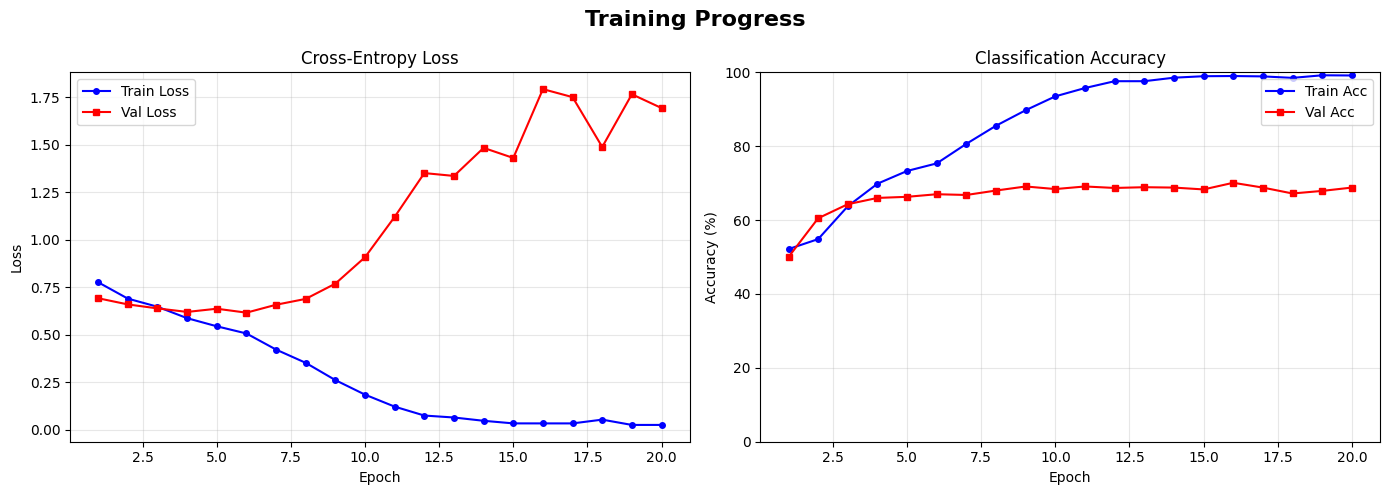

Final train acc: 99.15%  |  Final val acc: 68.80%


In [11]:
epochs = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training Progress', fontsize=16, fontweight='bold')

# Loss curves
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', markersize=4)
axes[0].plot(epochs, history['val_loss'],   'r-s', label='Val Loss',   markersize=4)
axes[0].set_title('Cross-Entropy Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(epochs, [a*100 for a in history['train_acc']], 'b-o', label='Train Acc', markersize=4)
axes[1].plot(epochs, [a*100 for a in history['val_acc']],   'r-s', label='Val Acc',   markersize=4)
axes[1].set_title('Classification Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim([0, 100])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f'Final train acc: {history["train_acc"][-1]*100:.2f}%  |  Final val acc: {history["val_acc"][-1]*100:.2f}%')

## 🧪 Step 7 — Evaluation on Test Set

### 7a. Sample Predictions
We display 10 test images with their true and predicted labels.  
Green title = correct prediction, Red title = wrong prediction.

This gives an immediate qualitative sense of what kinds of images trip up the model.

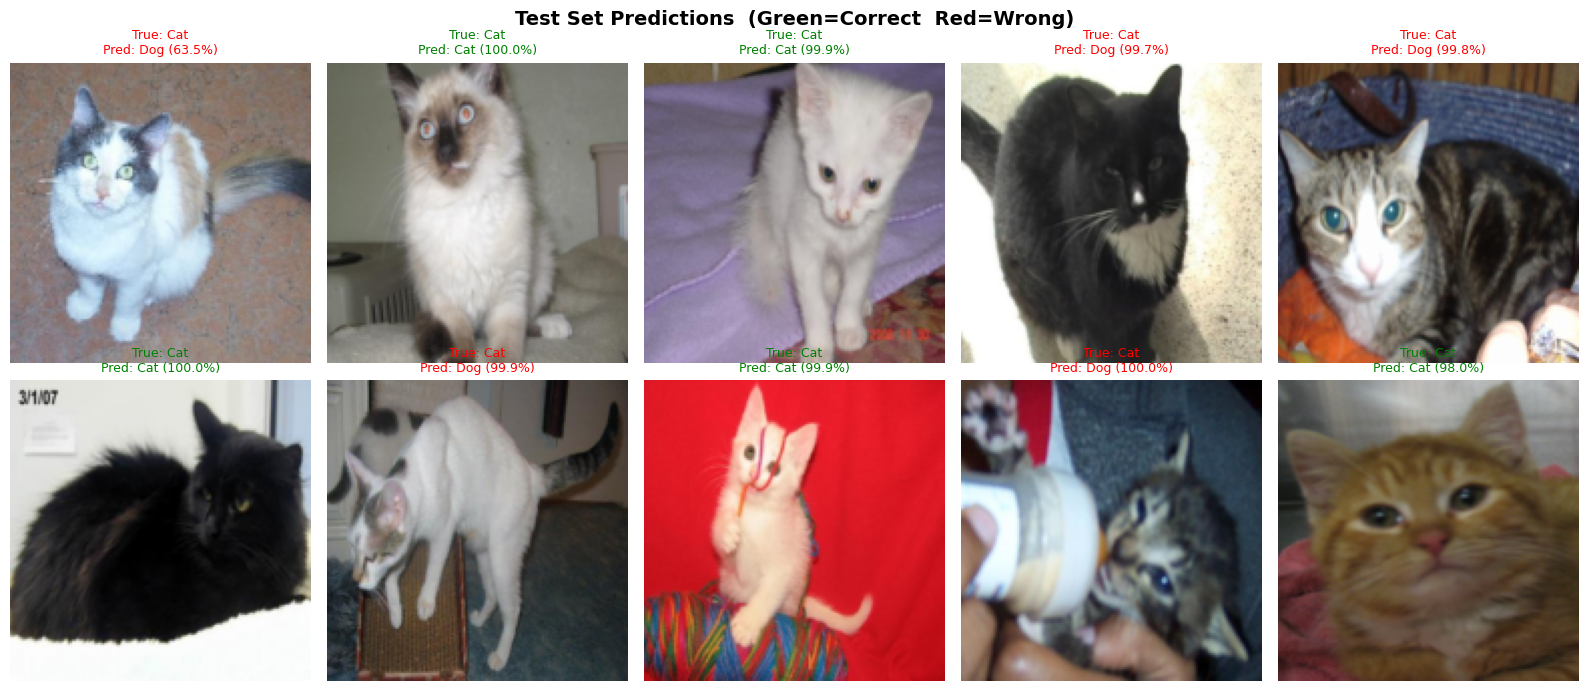

In [12]:
model.eval()

def denormalize(tensor):
    """Undo ImageNet normalization for display."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (tensor * std + mean).clamp(0, 1)

# Grab one batch of test images
images_b, labels_b = next(iter(test_loader))
with torch.no_grad():
    logits_b = model(images_b.to(DEVICE))
    probs_b  = F.softmax(logits_b, dim=1).cpu()
    preds_b  = probs_b.argmax(dim=1)

# Display first 10
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Test Set Predictions  (Green=Correct  Red=Wrong)', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    img = denormalize(images_b[i]).permute(1, 2, 0).numpy()
    true_lbl = labels_b[i].item()
    pred_lbl = preds_b[i].item()
    confidence = probs_b[i, pred_lbl].item() * 100
    color = 'green' if true_lbl == pred_lbl else 'red'
    ax.imshow(img)
    ax.set_title(f'True: {CLASS_NAMES[true_lbl]}\nPred: {CLASS_NAMES[pred_lbl]} ({confidence:.1f}%)',
                 color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 🧪 Step 7b — Full Test Set Evaluation

In [13]:
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        logits = model(images.to(DEVICE))
        probs  = F.softmax(logits, dim=1).cpu()
        preds  = probs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_probs.extend(probs.tolist())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

overall_acc = (all_preds == all_labels).mean()
print(f'Test Accuracy: {overall_acc*100:.2f}%\n')
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Test Accuracy: 70.10%

              precision    recall  f1-score   support

         Cat       0.70      0.70      0.70       500
         Dog       0.70      0.70      0.70       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



## 🟦 Step 7c — Confusion Matrix

The 2×2 confusion matrix summarizes all test predictions:

| | Predicted Cat | Predicted Dog |
|--|--|--|
| **True Cat** | TP | FN |
| **True Dog** | FP | TN |

- **TP (True Positive)**: Correctly identified cats.
- **TN (True Negative)**: Correctly identified dogs.
- **FP (False Positive)**: Dogs misclassified as cats.
- **FN (False Negative)**: Cats misclassified as dogs.

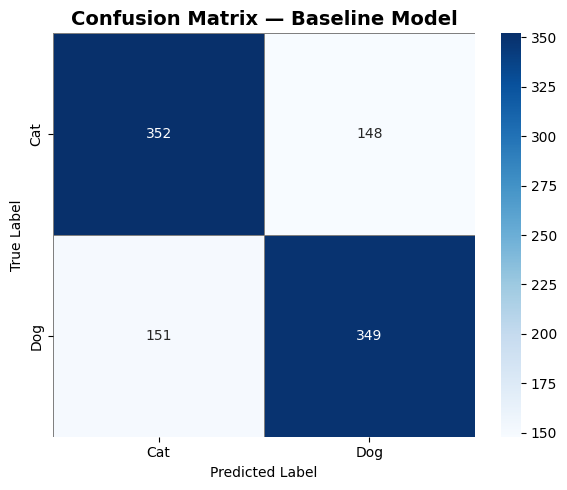

TP=352  FN=148  FP=151  TN=349
Cat recall (sensitivity): 0.704
Dog recall (sensitivity): 0.698


In [14]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix — Baseline Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

TP = cm[0,0]; FN = cm[0,1]; FP = cm[1,0]; TN = cm[1,1]
print(f'TP={TP}  FN={FN}  FP={FP}  TN={TN}')
print(f'Cat recall (sensitivity): {TP/(TP+FN):.3f}')
print(f'Dog recall (sensitivity): {TN/(TN+FP):.3f}')

## 🔍 Step 7d — Error Analysis

Looking at misclassified images helps us understand **why** the model makes mistakes. Common reasons:

1. **Ambiguous composition**: Animal occupies a small portion of the frame; background dominates the conv feature maps.
2. **Unusual pose or angle**: Side-on or top-down views that don't match the most common training pose.
3. **Breed similarity**: Some cats have dog-like features (e.g., Maine Coons) and vice versa.
4. **Low confidence**: Predictions near 50%–55% are essentially a coin flip.
5. **Over-represented background**: Water, grass, or furniture patterns the model learned to associate with the wrong class.

Total misclassified: 299 / 1000  (29.9%)


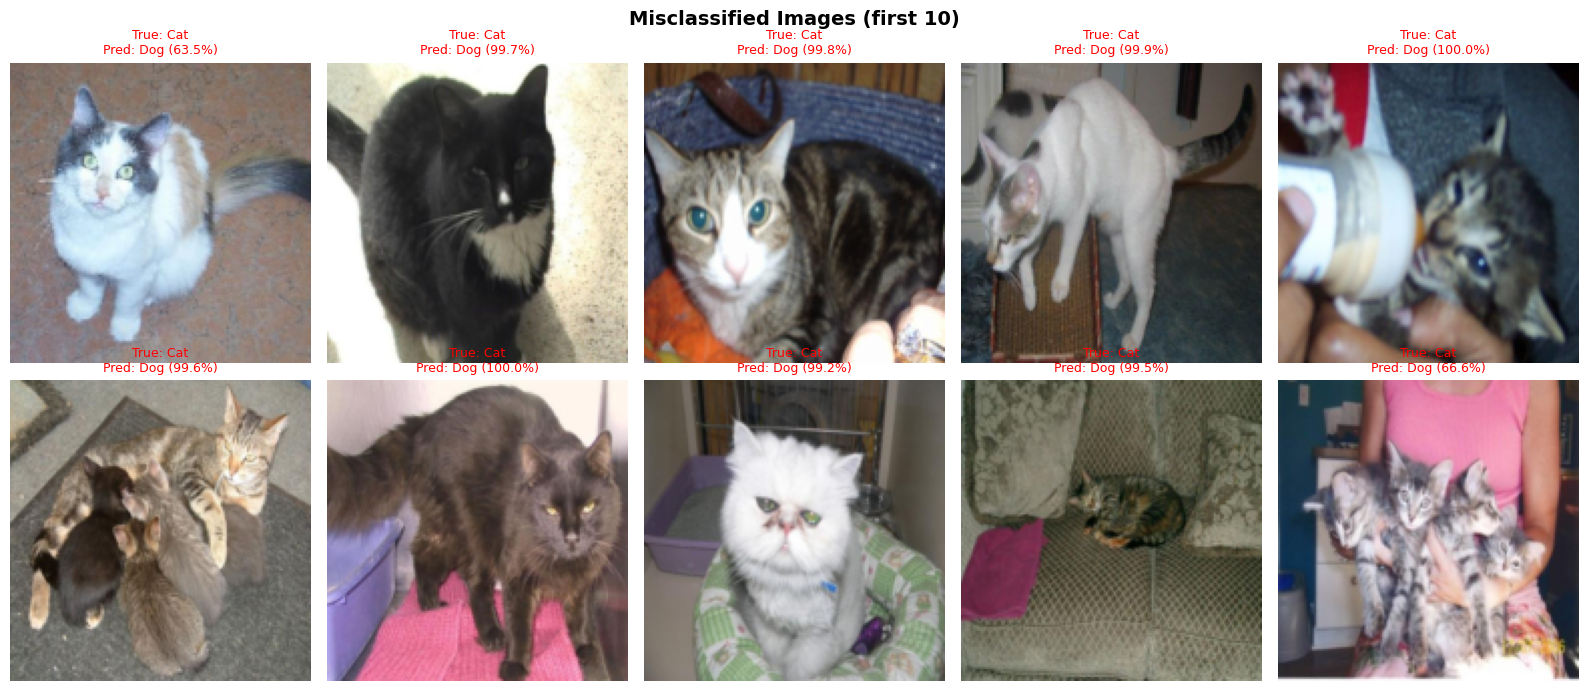

In [15]:
# Find misclassified indices in the test set
wrong_mask = all_preds != all_labels
wrong_idx  = np.where(wrong_mask)[0]

print(f'Total misclassified: {len(wrong_idx)} / {len(all_labels)}  '
      f'({len(wrong_idx)/len(all_labels)*100:.1f}%)')

# Show up to 10 errors
n_show = min(10, len(wrong_idx))
chosen = wrong_idx[:n_show]

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle(f'Misclassified Images (first {n_show})', fontsize=14, fontweight='bold')

for ax_i, idx in enumerate(chosen):
    ax = axes[ax_i // 5, ax_i % 5]
    img_tensor, _ = test_dataset[idx]
    img = denormalize(img_tensor).permute(1, 2, 0).numpy()
    true_lbl = all_labels[idx]
    pred_lbl = all_preds[idx]
    conf     = all_probs[idx, pred_lbl] * 100
    ax.imshow(img)
    ax.set_title(f'True: {CLASS_NAMES[true_lbl]}\nPred: {CLASS_NAMES[pred_lbl]} ({conf:.1f}%)',
                 color='red', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 🚀 Step 8 — Improvement Experiments

We now systematically vary one architectural parameter at a time and compare results to the **baseline**:

| Experiment | Change | Expected Effect |
|------------|--------|-----------------|
| **A — Deeper** | 4 Conv blocks [32,64,128,256] | More abstract features; risk of overfitting |
| **B — Wider** | Kernels [64,128,256], FC=1024 | More capacity per layer; more parameters |
| **C — Fewer Kernels** | Kernels [16,32,64] | Faster but less expressive |

A helper function `train_and_evaluate()` runs the full pipeline for any model configuration and returns its confusion matrix and accuracy so we can compare everything at the end.

**Note:** Each experiment resets the model weights and optimizer from scratch.

In [16]:
def train_and_evaluate(kernels, fc_units, fc_layers=1, label='Model',
                       num_epochs=NUM_EPOCHS, lr=LEARNING_RATE):
    """Train a CatDogCNN configuration and return (test_acc, confusion_matrix)."""
    print(f'\n{'='*60}')
    print(f'  Experiment: {label}')
    print(f'  Kernels={kernels}  FC_units={fc_units}  Epochs={num_epochs}')
    print(f'{'='*60}')

    mdl = CatDogCNN(kernels=kernels, fc_units=fc_units, fc_layers=fc_layers).to(DEVICE)
    opt = optim.Adam(mdl.parameters(), lr=lr, weight_decay=1e-4)

    hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(1, num_epochs + 1):
        mdl.train()
        tl, tc, tt = 0.0, 0, 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            opt.zero_grad()
            out  = mdl(imgs)
            loss = criterion(out, lbls)
            loss.backward()
            opt.step()
            tl += loss.item()*imgs.size(0); tc += (out.argmax(1)==lbls).sum().item(); tt+=lbls.size(0)

        mdl.eval()
        vl, vc, vt = 0.0, 0, 0
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                out  = mdl(imgs)
                loss = criterion(out, lbls)
                vl += loss.item()*imgs.size(0); vc += (out.argmax(1)==lbls).sum().item(); vt+=lbls.size(0)

        hist['train_loss'].append(tl/tt); hist['train_acc'].append(tc/tt)
        hist['val_loss'].append(vl/vt);   hist['val_acc'].append(vc/vt)
        if epoch % 5 == 0 or epoch == num_epochs:
            print(f'  Epoch {epoch:2d}/{num_epochs}  TrainAcc={tc/tt:.4f}  ValAcc={vc/vt:.4f}')

    # Confusion matrix
    preds_all, labels_all = [], []
    mdl.eval()
    with torch.no_grad():
        for imgs, lbls in test_loader:
            preds_all.extend(mdl(imgs.to(DEVICE)).argmax(1).cpu().tolist())
            labels_all.extend(lbls.tolist())

    test_acc = (np.array(preds_all)==np.array(labels_all)).mean()
    cm_ = confusion_matrix(labels_all, preds_all)
    print(f'  ✅ Final test accuracy: {test_acc*100:.2f}%')

    # Plot loss curves
    epochs_ = range(1, num_epochs+1)
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'Training Curves — {label}', fontweight='bold')
    plt.subplot(1,2,1); plt.plot(epochs_,hist['train_loss'],'b',label='Train'); plt.plot(epochs_,hist['val_loss'],'r',label='Val')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True,alpha=0.3)
    plt.subplot(1,2,2); plt.plot(epochs_,[a*100 for a in hist['train_acc']],'b',label='Train'); plt.plot(epochs_,[a*100 for a in hist['val_acc']],'r',label='Val')
    plt.title('Accuracy (%)'); plt.xlabel('Epoch'); plt.ylim([0,100]); plt.legend(); plt.grid(True,alpha=0.3)
    plt.tight_layout(); plt.show()

    return test_acc, cm_


# Store results for comparison at the end
results = {}
results['Baseline [32,64,128] FC=512'] = (best_val_acc,
    confusion_matrix(all_labels, all_preds))


  Experiment: Experiment A — Deeper [32,64,128,256] FC=512
  Kernels=[32, 64, 128, 256]  FC_units=512  Epochs=20


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch  5/20  TrainAcc=0.6255  ValAcc=0.6180


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 10/20  TrainAcc=0.7975  ValAcc=0.7090


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 15/20  TrainAcc=0.9050  ValAcc=0.7300


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 20/20  TrainAcc=0.9730  ValAcc=0.7120


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  ✅ Final test accuracy: 71.20%


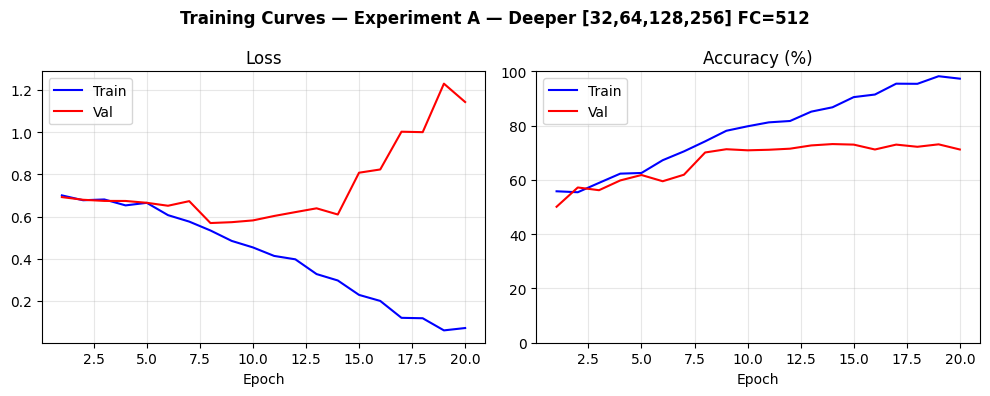

In [17]:
# ── Experiment A — Deeper Network ────────────────────────────────────────────
# Adding a 4th Conv block increases the depth of the feature hierarchy.
# The model can now learn more abstract representations (e.g., full faces vs. just edges).
# Risk: with only 2,000 training images, the extra parameters may cause overfitting.
# Compare the val_loss curve — if it diverges from train_loss, overfitting is occurring.
acc_A, cm_A = train_and_evaluate(
    kernels  = [32, 64, 128, 256],
    fc_units = 512,
    label    = 'Experiment A — Deeper [32,64,128,256] FC=512'
)
results['Exp A — Deeper'] = (acc_A, cm_A)


  Experiment: Experiment B — Wider [64,128,256] FC=1024
  Kernels=[64, 128, 256]  FC_units=1024  Epochs=20


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch  5/20  TrainAcc=0.6090  ValAcc=0.5810


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 10/20  TrainAcc=0.8170  ValAcc=0.6140


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 15/20  TrainAcc=0.9710  ValAcc=0.5910


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 20/20  TrainAcc=0.9905  ValAcc=0.6180


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  ✅ Final test accuracy: 61.80%


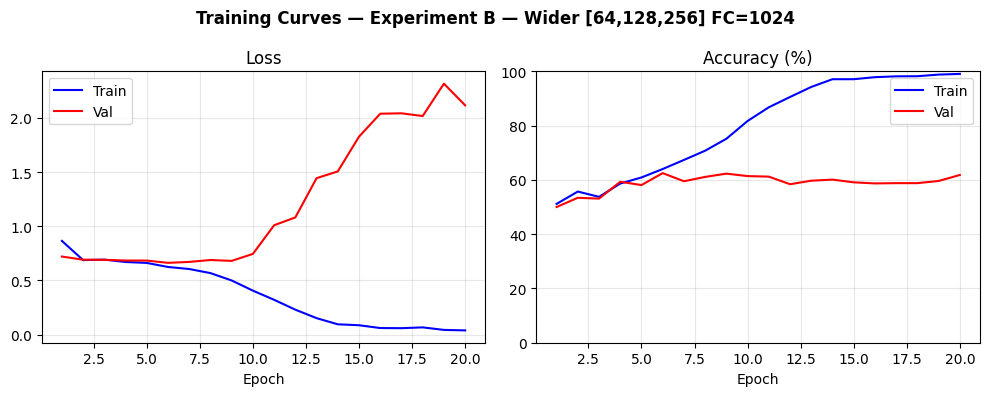

In [18]:
# ── Experiment B — Wider Network ─────────────────────────────────────────────
# Doubling kernel counts and FC units gives the model more representational capacity.
# Each Conv layer can detect more diverse patterns simultaneously.
# Trade-off: roughly 4× more parameters → more memory, slower training.
# If data is the bottleneck this won't help much; if model capacity was the bottleneck, it will.
acc_B, cm_B = train_and_evaluate(
    kernels  = [64, 128, 256],
    fc_units = 1024,
    label    = 'Experiment B — Wider [64,128,256] FC=1024'
)
results['Exp B — Wider'] = (acc_B, cm_B)


  Experiment: Experiment C — Fewer Kernels [16,32,64] FC=256
  Kernels=[16, 32, 64]  FC_units=256  Epochs=20


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch  5/20  TrainAcc=0.7920  ValAcc=0.6670


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 10/20  TrainAcc=0.9620  ValAcc=0.6690


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 15/20  TrainAcc=0.9905  ValAcc=0.6830


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Epoch 20/20  TrainAcc=0.9960  ValAcc=0.6830


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  ✅ Final test accuracy: 68.30%


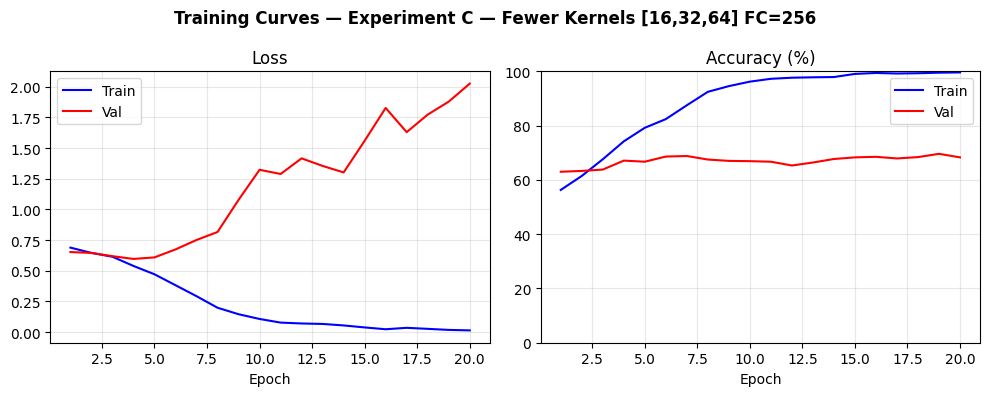

In [19]:
# ── Experiment C — Fewer Kernels ─────────────────────────────────────────────
# A more compact model trains faster and may generalize better if the baseline was overfitting.
# With fewer parameters, the model is forced to learn only the most discriminative features.
# Expect slightly lower accuracy but a tighter train/val gap (less overfitting).
acc_C, cm_C = train_and_evaluate(
    kernels  = [16, 32, 64],
    fc_units = 256,
    label    = 'Experiment C — Fewer Kernels [16,32,64] FC=256'
)
results['Exp C — Fewer Kernels'] = (acc_C, cm_C)

## 📊 Step 8b — Comparison: All Confusion Matrices

We display all four confusion matrices side-by-side and print a summary table so we can directly compare which architectural change had the most impact.

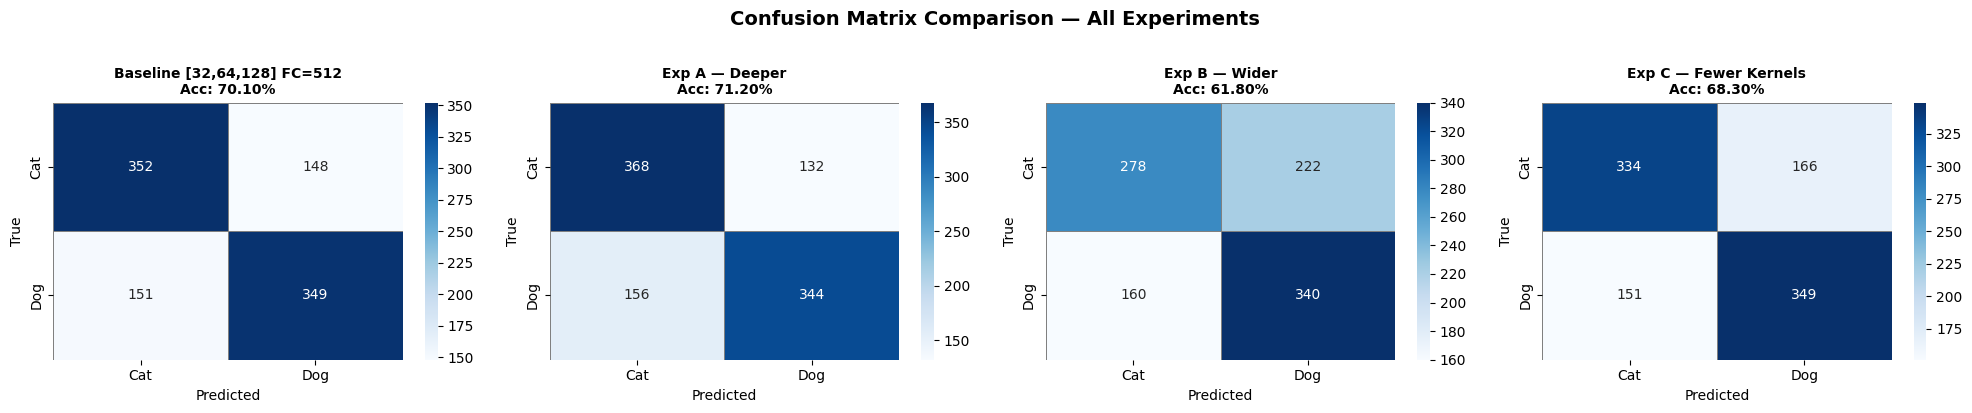


Model                                          Test Accuracy
------------------------------------------------------------
Baseline [32,64,128] FC=512                           70.10%
Exp A — Deeper                                        71.20%
Exp B — Wider                                         61.80%
Exp C — Fewer Kernels                                 68.30%


In [20]:
n = len(results)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
if n == 1: axes = [axes]

for ax, (name, (acc, cm_)) in zip(axes, results.items()):
    sns.heatmap(cm_, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                linewidths=0.5, linecolor='gray', ax=ax)
    ax.set_title(f'{name}\nAcc: {acc*100:.2f}%', fontsize=10, fontweight='bold')
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

plt.suptitle('Confusion Matrix Comparison — All Experiments', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print(f'\n{"Model":<45} {"Test Accuracy":>14}')
print('-' * 60)
for name, (acc, _) in results.items():
    print(f'{name:<45} {acc*100:>13.2f}%')

## 🏁 Conclusions

This notebook demonstrated a complete end-to-end CNN binary classification pipeline:

1. **Data loading** with `ImageFolder` and automatic label assignment from folder names.
2. **Preprocessing** (resize, normalize) via `transforms.Compose`.
3. **CNN architecture** with configurable Conv+Pool blocks, ReLU activations, Dropout, and a Softmax output.
4. **Training** with Adam optimizer and Cross-Entropy loss, tracking both loss and accuracy.
5. **Evaluation** with confusion matrix, classification report, and visual error analysis.
6. **Improvement experiments** comparing deeper, wider, and more compact architectures.

### 🔑 Key Takeaways
- Normalization using ImageNet statistics accelerates training on RGB images.
- Dropout is a simple but effective regularizer for small datasets.
- Deeper networks can learn richer features but risk overfitting on small datasets.
- Comparing confusion matrices across experiments makes it easy to see whether a change helps cats, dogs, or both.

### ⏭️ Next Steps
- **Data augmentation** (random flips, crops, color jitter) to artificially expand the training set.
- **Transfer learning** using a pretrained ResNet or EfficientNet backbone from `torchvision.models`.
- **Learning rate scheduling** (e.g., `CosineAnnealingLR`) for finer convergence control.
